In [1]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import numpy as np

def wrap(job,job_id,task_id):
    def singlerun(kaf,L,run):
        import numpy as np
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        rm = 0.005
        R=2*rm
        D = 1
        kd= 4.0*math.pi*D*2*rm
        ka = kaf*kd
        kon = (ka*kd)/(ka+kd)
        Vac=L**3
        N = 100
        M = max(int(min(cbrt(N), L / (2 * rm))), 3)
        C=float(N)/Vac
        with species_attributes():
            A |  {'D': str(0), 'radius':str(rm)}
            B |  {'D': str(D), 'radius':str(rm)}

        with reaction_rules():#for spa and egfrd
            A + B > B | ka

        m2 = get_model()

        w = egfrd.EGFRDWorld(ones()*L,Integer3(M,M,M))
        w.bind_to(m2)
        na=1
        w.add_molecules(Species('A'), na)
        w.add_molecules(Species('B'), N)
        sim = egfrd.EGFRDSimulator(w)
        sim.initialize()
        simt=0
        while na==1:
            sim.step()
            na = w.num_particles_exact(Species('A'))
            simt=sim.t()
        return simt,C
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

kaf=10.
simrun=5000
Ls=[3,2.5,2,1,0.5,0.1]
Ls=[4,3.5]
rxt=[]
conc=[]
for L in Ls:
    jobs=[{'kaf':kaf,'L':L}]
    #res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=350,path='tmp',modules=('numpy','ecell4','math'))[0]
    conc.append(res[0][1])
    rxt.append(np.mean([r[0] for r in res]))
print('finish') 

NameError: name 'res' is not defined

In [24]:
rxt=np.array(rxt)
conc=np.array(conc)
print(conc)
print(rxt)
print(rxt*conc)
print('phi',conc*4*math.pi*0.005**3/3)

[1.5625     2.33236152]
[6.86095951 3.29154353]
[10.72024924  7.67706946]
phi [8.18123087e-07 1.22122163e-06]


In [2]:
rxt=np.array(rxt)
conc=np.array(conc)
print(conc)
print(rxt)
print('phi',conc*4*math.pi*0.005**3/3)

[3.7037037e+00 6.4000000e+00 1.2500000e+01 1.0000000e+02 8.0000000e+02
 1.0000000e+05]
[2.65432419e+00 1.36608182e+00 7.15382003e-01 9.32151634e-02
 9.63539119e-03 3.58870174e-05]
phi [1.93925472e-06 3.35103216e-06 6.54498469e-06 5.23598776e-05
 4.18879020e-04 5.23598776e-02]


kaf 10.0


TypeError: can't multiply sequence by non-int of type 'list'

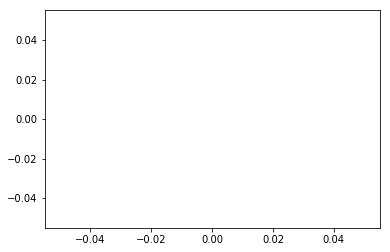

In [12]:
print('kaf',kaf)
rm = 0.005
R=2*rm
D = 1
kd= 4.0*math.pi*D*R
ka = kaf*kd
kon = (ka*kd)/(ka+kd)

plt.plot(conc,[1/kon]*len(conc),label='1/kon')
plt.plot(conc,[1/ka]*len(conc),label='1/ka')
plt.semilogx(conc,rxt*conc,'o-')
plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')

kaf 0.1


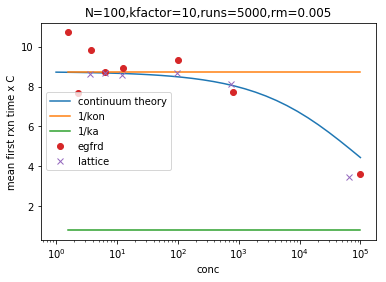

In [16]:
print('kaf',kaf)
rm = 0.005
R=2*rm
D = 1
kd= 4.0*math.pi*D*R
kaf=10
ka = kaf*kd
kon = (ka*kd)/(ka+kd)

econc=np.array([1.5625 ,    2.33236152, 3.7037037e+00, 6.4000000e+00 ,1.2500000e+01, 1.0000000e+02 ,8.0000000e+02,
 1.0000000e+05])
etime=np.array([6.86095951, 3.29154353,2.65432419e+00, 1.36608182e+00 ,7.15382003e-01 ,9.32151634e-02,
 9.63539119e-03, 3.58870174e-05])
latconc=np.array([3.64871158e+00 ,6.30025812e+00 ,1.21675553e+01 ,9.55771445e+01,
 7.39314196e+02, 6.59368514e+04])
lattime=[2.36377904e+00, 1.38089638e+00, 7.03442977e-01, 9.09068837e-02,
 1.10260900e-02, 5.28925700e-05]

def tautheory(c): #eq4.5 Agmon n Szabo
    a=ka*R/(ka+kd)
    return 1./(c*4*math.pi*D*a*(1+math.sqrt(4*math.pi*a**3*c)))

C=np.logspace(0,5,30)
tau=np.array([c*tautheory(c) for c in C])
plt.semilogx(C,tau,'-',label='continuum theory')
plt.plot(econc,[1/kon]*len(econc),label='1/kon')
plt.plot(econc,[1/ka]*len(econc),label='1/ka')
plt.semilogx(econc,etime*econc,'o',label='egfrd')
plt.semilogx(latconc,lattime*latconc,'x',label='lattice')
plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')
plt.title('N=100,kfactor={},runs={},rm={}'.format(kaf,simrun,rm))
plt.legend(loc='best')
#plt.savefig("./fig.png",format='png',dpi=900)    

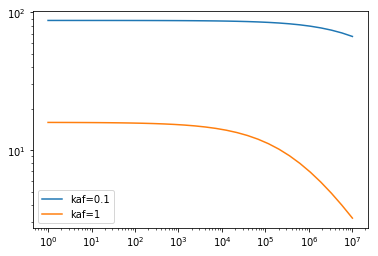

In [31]:
rm = 0.005
R=2*rm
D = 1
kd= 4.0*math.pi*D*R

def tautheory(c): #eq4.5 Agmon n Szabo
    a=ka*R/(ka+kd)    
    return 1./(c*4*math.pi*D*a*(1+math.sqrt(4*math.pi*a**3*c)))

C=np.logspace(0,7,30)
for kf in [0.1,1]:
    ka = kf*kd
    tau=np.array([c*tautheory(c) for c in C])
    plt.loglog(C,tau,'-',label='kaf='+str(kf))
plt.legend()